In [ ]:
# !pip install catboost
# !pip install xgboost
# !pip install pydotplus
# !pip install graphviz

In [104]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import font_manager, rc
import tslearn
from datetime import datetime
import missingno as msno
import seaborn as sns
from tqdm import tqdm 
import warnings
import warnings
warnings.filterwarnings(action='ignore')
warnings.filterwarnings("ignore")

In [105]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from xgboost import plot_tree

In [106]:
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 작업폴더
os.chdir('C:\\Users\\user\\Python\\project_mosquito')

In [107]:
df=pd.read_csv('df_final.csv',encoding='ansi')
df=df.drop(['Unnamed: 0','lon','lat','sgg','emd'],axis=1)
df['date'] = pd.to_datetime(df['date']) #날짜를 pandas Timestamp 형태로 변경 
df.head(2)

,loc_name,mosquito,date,used_area,agri_land,forest,grass,wet_land,barren,water,avg_temp,min_temp,max_temp,rainfall,avg_wind,avg_humi,sma14_temp,sma14_wind,sma14_humi,cum28_rain
0,보건환경연구원,1,2016-04-05,0.926921,0.0049,0.0,0.057981,0.0,0.010198,0.0,9.4,6.5,12.9,0.0,2.8,75.4,9.085714,2.985714,68.357143,0.1
1,동구보건소,3,2016-04-05,0.815430,0.0000,0.0,0.154623,0.0,0.029948,0.0,9.4,6.5,12.9,0.0,2.8,75.4,9.085714,2.985714,68.357143,0.1


In [108]:
A=df.loc[df['barren'].notna(),:]

#종속변수가 결측치인 부분과 아닌부분을 구분
df=A.loc[A['mosquito']!=-1,:]
df_na=A.loc[A['mosquito']==-1,:]

In [109]:
#최저/최고 기온과 평균기온과의 상관관계 높음
df.drop(['min_temp', 'max_temp'], axis=1, inplace=True)

## train set과 test set 분류

In [110]:
x=df[['barren', 'agri_land', 'forest','water', 'wet_land', 'used_area', 
      'grass', 'avg_temp','rainfall', 'avg_wind', 'avg_humi',
       'sma14_temp', 'sma14_wind', 'sma14_humi', 'cum28_rain']]
y=np.log(df['mosquito']+1)

x_train, x_test, y_train, y_test=train_test_split(x,y,random_state=42,test_size=0.2) #train,test분할

## Random Forest Regressor
#### 파라미터
- **n_estimators**: 결정 트리 개수
- **max_feature**:데이터의 feature를 참조할 비율
- **max_depth**: 트리 깊이
- **min_samples_leaf**:리프노드가 되기 위한 최소 샘플 데이터 수
- **min_samples_split**:노드를 분할하기 위한 최소한의 데이터 수

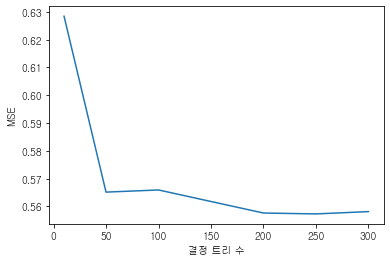

In [111]:
#n_estimators 조절
score=[]
mse=[]
list=[10,50,100,200,250,300]
for i in list:
    model = RandomForestRegressor(n_estimators=i)
    model.fit(x_train, y_train)
    
    prediction = model.predict(x_test)
    mse.append(mean_squared_error(y_test, prediction))
    score.append(model.score(x_test,y_test))

#mse plot
plt.plot(list, mse)
plt.xlabel('결정 트리 수')
plt.ylabel('MSE')
plt.show()    

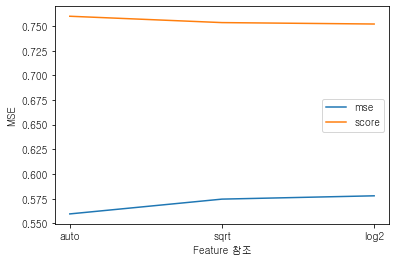

In [112]:
#max_feature 조절

score=[]
mse=[]
list=['auto','sqrt','log2']
for i in list:
    model = RandomForestRegressor(n_estimators=100,max_features=i)
    model.fit(x_train, y_train)
    
    prediction = model.predict(x_test)
    mse.append(mean_squared_error(y_test, prediction))
    score.append(model.score(x_test,y_test))

#mse,score plot    
plt.plot(list, mse,label='mse')
plt.legend()
plt.plot(list,score,label='score')
plt.legend()
plt.xlabel('Feature 참조')
plt.ylabel('MSE')
plt.show()

In [113]:
##위 값을 참고해 파라미터 조정

rf = RandomForestRegressor(n_estimators=100, 
                          max_features='sqrt') 
rf.fit(x_train, y_train)

prediction = rf.predict(x_test)
tr_prediction = rf.predict(x_train)
rf_train_score=rf.score(x_train, y_train)
rf_test_score=rf.score(x_test, y_test)
rf_train_mse=mean_squared_error(y_train, tr_prediction)
rf_test_mse=mean_squared_error(y_test, prediction)

In [114]:
print('train score:',rf_train_score)
print('test score:',rf_test_score)
print('train MSE:',rf_train_mse)
print('test MSE:',rf_test_mse)

train score: 0.967068568878109
test score: 0.7509450956448985
train MSE: 0.07925803629177963
test MSE: 0.5799923993670423


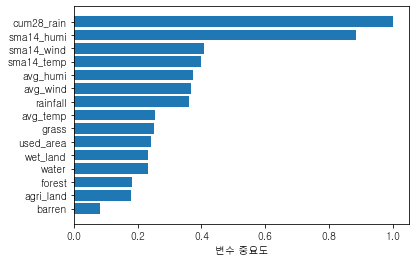

In [115]:
#변수 중요도 파악
featureImportance = rf.feature_importances_

featureImportance = featureImportance/featureImportance.max()
sorted_idx = np.argsort(featureImportance)
barPos = np.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, x)
plt.xlabel('변수 중요도')
plt.show()

## CatBoost Regressor
#### 파라미터
- **n_estimators**
- **learning_rate**

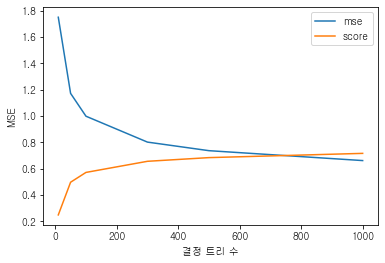

In [116]:
#n_estimators 조절
mse=[]
score=[]
list=[10,50,100,300,500,1000]
for i in list:
    model = CatBoostRegressor(n_estimators=i, 
                              learning_rate=0.05) 
    model.fit(x_train, y_train, verbose=0)
    
    prediction = model.predict(x_test)
    mse.append(mean_squared_error(y_test, prediction))
    score.append(model.score(x_test,y_test))

#mse,score plot
plt.plot(list, mse,label='mse')
plt.legend()
plt.plot(list,score,label='score')
plt.legend()
plt.xlabel('결정 트리 수')
plt.ylabel('MSE')
plt.show()  

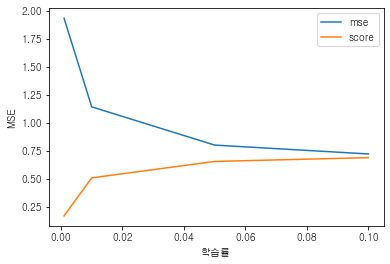

In [117]:
#learning_rate 조절
mse=[]
score=[]
list =[0.1,0.05,0.01,0.001]
for i in list:
    model = CatBoostRegressor(n_estimators=300, 
                              learning_rate=i) 
    model.fit(x_train, y_train, verbose=0)
    
    prediction = model.predict(x_test)
    mse.append(mean_squared_error(y_test, prediction))
    score.append(model.score(x_test,y_test))

#tree별 mse plot
plt.plot(list, mse,label='mse')
plt.legend()
plt.plot(list,score,label='score')
plt.legend()
plt.xlabel('학습률')
plt.ylabel('MSE')
plt.show()  

In [118]:
##위 값을 참고해
#파라미터 조정

from catboost import CatBoostRegressor
catb = CatBoostRegressor(n_estimators=300,
                         learning_rate=0.05)
    
catb.fit(x_train, y_train, verbose=0)

tr_prediction =catb.predict(x_train)
prediction =catb.predict(x_test)
catb_train_score=catb.score(x_train, y_train)
catb_test_score=catb.score(x_test, y_test)
catb_train_mse=mean_squared_error(y_train, tr_prediction)
catb_test_mse=mean_squared_error(y_test, prediction)

In [119]:
print('train score:',catb_train_score)
print('test score:',catb_test_score)
print('train MSE:',catb_train_mse)
print('test MSE:',catb_test_mse)

train score: 0.6857958062552133
test score: 0.6557176520929324
train MSE: 0.7562139434110234
test MSE: 0.8017555227004659


## AdaBoost Regressor
#### 파라미터
- **n_estimator**: 부스팅이 종료되는 최대 estimator 수
- **learning_rate**:각 부스팅 반복에서 분류기에 적용되는 가중치
- **loss**:가중치 업데이트시 사용할 손실 함수

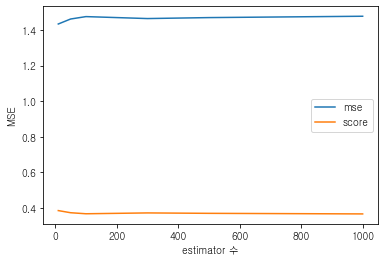

In [120]:
#n_estimators 조절
mse=[]
score=[]
list=[10,50,100,300,500,1000]
for i in list:
    model = AdaBoostRegressor(n_estimators=i)
    model.fit(x_train, y_train)
    
    prediction = model.predict(x_test)
    mse.append(mean_squared_error(y_test, prediction))
    score.append(model.score(x_test,y_test))

plt.plot(list, mse,label='mse')
plt.legend()
plt.plot(list,score,label='score')
plt.legend()
plt.xlabel('estimator 수')
plt.ylabel('MSE')
plt.show()

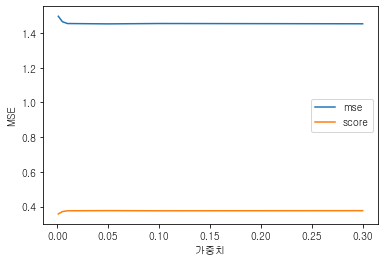

In [121]:
#learning_rate 조절
mse=[]
score=[]
list=[0.001,0.005,0.01,0.05,0.1,0.3]
for i in list:
    model = AdaBoostRegressor(n_estimators=300,
                             learning_rate=i)
    model.fit(x_train, y_train)
    
    prediction = model.predict(x_test)
    mse.append(mean_squared_error(y_test, prediction))
    score.append(model.score(x_test,y_test))
    
plt.plot(list, mse,label='mse')
plt.legend()
plt.plot(list,score,label='score')
plt.legend()
plt.xlabel('가중치')
plt.ylabel('MSE')
plt.show()

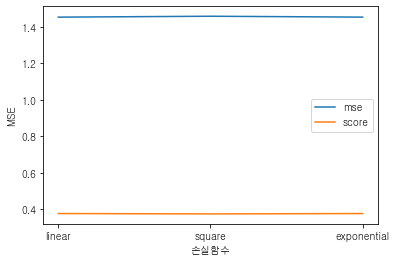

In [122]:
#loss 조절
mse=[]
score=[]
list=['linear', 'square', 'exponential']
for i in list:
    model = AdaBoostRegressor(n_estimators=300,
                             learning_rate=0.01,
                             loss=i)
    model.fit(x_train, y_train)
    
    prediction = model.predict(x_test)
    mse.append(mean_squared_error(y_test, prediction))
    score.append(model.score(x_test,y_test))
    
plt.plot(list, mse,label='mse')
plt.legend()
plt.plot(list,score,label='score')
plt.legend()
plt.xlabel('손실함수')
plt.ylabel('MSE')
plt.show()

In [123]:
#모델학습
ada = AdaBoostRegressor(n_estimators=1000,
                        loss='exponential',
                        learning_rate=0.01)
ada.fit(x_train,y_train)
tr_prediction = ada.predict(x_train)
prediction = ada.predict(x_test)
ada_train_score=ada.score(x_train, y_train)
ada_test_score=ada.score(x_test, y_test)
ada_train_mse=mean_squared_error(y_train, tr_prediction)
ada_test_mse=mean_squared_error(y_test, prediction)

In [124]:
print('train score:',ada_train_score)
print('test score:',ada_test_score)
print('train MSE:',ada_train_mse)
print('test MSE:',ada_test_mse)

train score: 0.4032755958030845
test score: 0.39002886849217955
train MSE: 1.4361721575042796
test MSE: 1.4204844551201223


## GradientBoost Regressor
#### 파라미터
- **loss**:최적화할 손실함수
- **learning_rate**:학습률
- **max_feature**:고려해야할 feature 수
- **n_estimator**:수행할 부스팅 단계 수

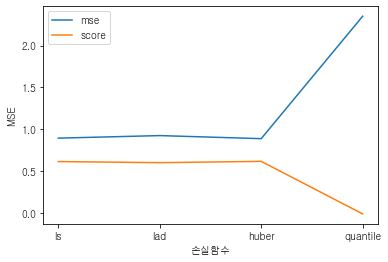

In [125]:
#loss 조절
mse=[]
score=[]
list=['ls','lad', 'huber','quantile']
for i in list:
    model = GradientBoostingRegressor(n_estimators=300,loss=i,learning_rate=0.05)
    model.fit(x_train, y_train)
   
    prediction = model.predict(x_test)
    mse.append(mean_squared_error(y_test, prediction))
    score.append(model.score(x_test,y_test))
    
plt.plot(list, mse,label='mse')
plt.legend()
plt.plot(list,score,label='score')
plt.legend()
plt.xlabel('손실함수')
plt.ylabel('MSE')
plt.show()

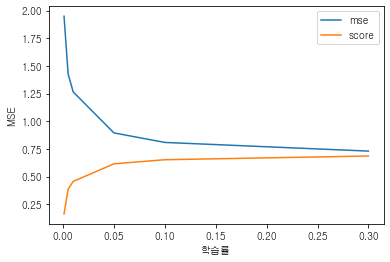

In [126]:
#learning_rate 조절
mse=[]
score=[]
list=[0.001,0.005,0.01,0.05,0.1,0.3]
for i in list:
    model = GradientBoostingRegressor(n_estimators=300,learning_rate=i)
    model.fit(x_train, y_train)
    
    prediction = model.predict(x_test)
    mse.append(mean_squared_error(y_test, prediction))
    score.append(model.score(x_test,y_test))
    
plt.plot(list, mse,label='mse')
plt.legend()
plt.plot(list,score,label='score')
plt.legend()
plt.xlabel('학습률')
plt.ylabel('MSE')
plt.show()

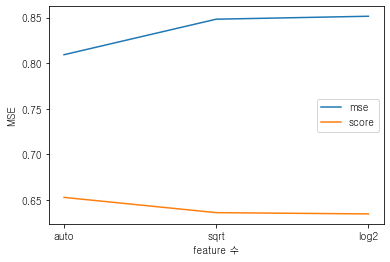

In [127]:
#max_feature 조절
mse=[]
score=[]
list=['auto','sqrt','log2']
for i in list:
    model = GradientBoostingRegressor(n_estimators=300,learning_rate=0.1,max_features=i)
    model.fit(x_train, y_train)
    
    prediction = model.predict(x_test)
    mse.append(mean_squared_error(y_test, prediction))
    score.append(model.score(x_test,y_test))
    
plt.plot(list, mse,label='mse')
plt.legend()
plt.plot(list,score,label='score')
plt.legend()
plt.xlabel('feature 수')
plt.ylabel('MSE')
plt.show()

In [128]:
gbr = GradientBoostingRegressor(loss='ls',learning_rate=0.1,max_features='auto',n_estimators=300)
gbr.fit(x_train, y_train)

tr_prediction = gbr.predict(x_train)
prediction = gbr.predict(x_test)
gbr_train_score=gbr.score(x_train, y_train)
gbr_test_score=gbr.score(x_test, y_test)
gbr_train_mse=mean_squared_error(y_train, tr_prediction)
gbr_test_mse=mean_squared_error(y_test, prediction)

In [129]:
print('train score:',gbr_train_score)
print('test score:',gbr_test_score)
print('train MSE:',gbr_train_mse)
print('test MSE:',gbr_test_mse)

train score: 0.6874116949649394
test score: 0.652553646756248
train MSE: 0.7523248878299007
test MSE: 0.8091237736955045


## XGBoost REgressor
#### 파라미터
- **booster**:사용할 부스터
- **learning_rate**:학습률
- **subsample**:하위 샘플 비율

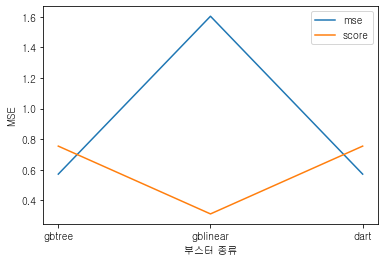

In [130]:
#booster 선택
mse=[]
score=[]
list=['gbtree','gblinear','dart']
for i in list:
    model =  XGBRegressor(n_estimators=1000,booster=i)
    model.fit(x_train, y_train)
    
    prediction = model.predict(x_test)
    mse.append(mean_squared_error(y_test, prediction))
    score.append(model.score(x_test,y_test))
    
plt.plot(list, mse,label='mse')
plt.legend()
plt.plot(list,score,label='score')
plt.legend()
plt.xlabel('부스터 종류')
plt.ylabel('MSE')
plt.show()

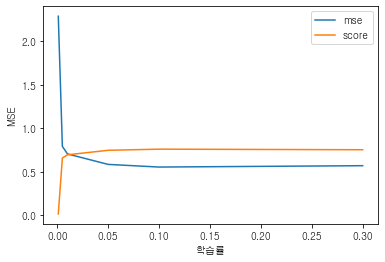

In [131]:
#learning_rate 조절
mse=[]
score=[]
list=[0.001,0.005,0.01,0.05,0.1,0.3]
for i in list:
    model =  XGBRegressor(n_estimators=1000,booster='gbtree',learning_rate=i)
    model.fit(x_train, y_train)
    
    prediction = model.predict(x_test)
    mse.append(mean_squared_error(y_test, prediction))
    score.append(model.score(x_test,y_test))
    
plt.plot(list, mse,label='mse')
plt.legend()
plt.plot(list,score,label='score')
plt.legend()
plt.xlabel('학습률')
plt.ylabel('MSE')
plt.show()

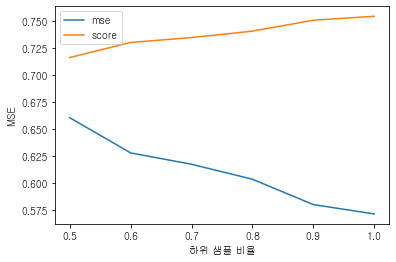

In [132]:
#subsample 조절
mse=[]
score=[]
list=[0.5,0.6,0.7,0.8,0.9,1]
for i in list:
    model =  XGBRegressor(n_estimators=1000,booster='gbtree',subsample=i)
    model.fit(x_train, y_train)
    
    prediction = model.predict(x_test)
    mse.append(mean_squared_error(y_test, prediction))
    score.append(model.score(x_test,y_test))
    
plt.plot(list, mse,label='mse')
plt.legend()
plt.plot(list,score,label='score')
plt.legend()
plt.xlabel('하위 샘플 비율')
plt.ylabel('MSE')
plt.show()

In [147]:
xg = XGBRegressor(n_estimators=1000,subsample=1,booster='gbtree',learning_rate=0.05)
xg.fit(x_train,y_train)

tr_prediction = xg.predict(x_train)
prediction = xg.predict(x_test)
xg_train_score=xg.score(x_train, y_train)
xg_test_score=xg.score(x_test, y_test)
xg_train_mse=mean_squared_error(y_train, tr_prediction)
xg_test_mse=mean_squared_error(y_test, prediction)

In [148]:
print('train score:',xg_train_score)
print('test score:',xg_test_score)
print('train MSE:',xg_train_mse)
print('test MSE:',xg_test_mse)

train score: 0.8618105433926552
test score: 0.7483118864716797
train MSE: 0.33258879416405185
test MSE: 0.5861245464547101


## 성능비교 시각화

In [149]:
index=['random forest', 'catboost' ,'adaboost','gradientboost', 'xgboost']
train_scores=[rf_train_score, catb_train_score, ada_train_score, gbr_train_score, xg_train_score]
test_scores=[rf_test_score, catb_test_score, ada_test_score, gbr_test_score, xg_test_score]
train_mses=[rf_train_mse, catb_train_mse, ada_train_mse, gbr_train_mse, xg_train_mse]
test_mses=[rf_test_mse, catb_test_mse, ada_test_mse, gbr_test_mse, xg_test_mse]

In [150]:
pd.DataFrame([train_scores, test_scores], columns = index, index=['train score', 'test score'])

,random forest,catboost,adaboost,gradientboost,xgboost
train score,0.967069,0.685796,0.403276,0.687412,0.861811
test score,0.750945,0.655718,0.390029,0.652554,0.748312


In [151]:
pd.DataFrame([train_mses, test_mses], columns = index, index=['train mse', 'test mse'])

,random forest,catboost,adaboost,gradientboost,xgboost
train mse,0.079258,0.756214,1.436172,0.752325,0.332589
test mse,0.579992,0.801756,1.420484,0.809124,0.586125


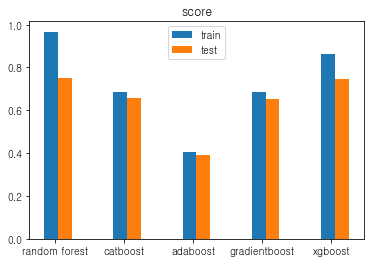

In [155]:
x=np.arange(len(index))
plt.bar(x-0.05,train_scores,label='train',width=0.2)
plt.bar(x+0.15,test_scores,label='test',width=0.2)
plt.xticks(x, index)
plt.legend()
plt.title('score')
plt.show()

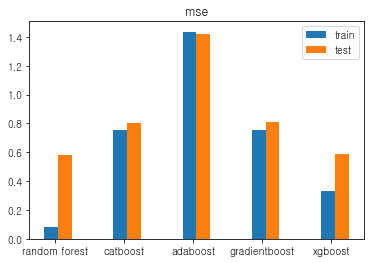

In [154]:
x=np.arange(len(index))
plt.bar(x-0.05,train_mses,label='train',width=0.2)
plt.bar(x+0.15,test_mses,label='test',width=0.2)
plt.xticks(x, index)
plt.legend()
plt.title('mse')
plt.show()

# 최종 모델은 xgboost

In [159]:
xg.save_model("XGBoost_new.json")